In [21]:
import random
from functools import partial
from PIL import Image
import os
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import v2, transforms
#import torchinfo
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

torch.backends.cudnn.enabled = True

In [22]:
NUM_CHANNELS = 3  # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
TRAINING_SIZE = 20
VALIDATION_SIZE = 5  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 16  # 64
NUM_EPOCHS = 100
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
RECORDING_STEP = 0

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 16

In [23]:
if not os.path.exists('test'):
    os.mkdir('test')
    for i in range(1, 51):
        input_filename = f"test_set_images/test_{i}/test_{i}.png"
        im = Image.open(input_filename)
        output_path = f'test/test_{i}.png'
        im.save(output_path)
    print('created directory test')

In [24]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches


def extract_data(dir_name, nb_sample=None):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    file_list = os.listdir(dir_name)

    if not nb_sample:
        for file in file_list:
            image_filename = dir_name + "/" + file
            img = mpimg.imread(image_filename)
            imgs.append(img)
    else:
        nb_sample = min(len(file_list), nb_sample)
        for file in file_list[:nb_sample]:
            image_filename = dir_name + "/" + file
            img = mpimg.imread(image_filename)
            imgs.append(img)

    num_images = len(imgs)

    img_patches = [
        img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)
    ]
    data = [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]

    return data


class RoadSegmentationDataset(Dataset):
    def __init__(self, image_path, mask_path, num_images, transform=None, train_split=None):
        self.split = train_split
        if self.split:
            self.images = extract_data(image_path, num_images)
            self.masks = extract_data(mask_path, num_images)
            self.images = [self.images[i] for i in self.split]
            self.masks = [self.masks[i] for i in self.split]

        else:
            self.images = extract_data(image_path, num_images)

        self.transform = transform
        self.totensor = transforms.Compose([
    transforms.ToTensor(),])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.split:
            image = self.images[idx]
            mask = self.masks[idx]
            if self.transform:
                image = self.transform(image)
                mask = self.totensor(mask)
            return (image, mask)
        else:
            image = self.images[idx]
            if self.transform:
                image = self.transform(image)
            return image
            
        
    
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images in loader:
        total_images += images.size(0)
        for i in range(3):  # For each channel
            mean[i] += images[:, i, :, :].mean()
            std[i] += images[:, i, :, :].std()

    mean /= total_images
    std /= total_images
    return mean, std

def get_dataloaders(
    batch_size, 
    num_images,
    image_dir,
    mask_dir):
    train_indices, val_indices = train_test_split(range(num_images), test_size=0.2, random_state=42, shuffle=True)
    print(1)
    train_dataset_for_stats = RoadSegmentationDataset(image_dir, mask_dir, num_images, transform=transforms.ToTensor(), train_split=train_indices)
    print(2)
    # mean, std = compute_mean_std(train_dataset_for_stats)
    # print(3)
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    # transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    # ])

    train_set = RoadSegmentationDataset(image_dir, mask_dir, num_images, transform=transform, train_split=train_indices)

    train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the iteration order over the dataset
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
    num_workers=0,
    )
    print(4)

    val_set = RoadSegmentationDataset(image_dir, mask_dir, num_images, transform=transform, train_split=val_indices)

    val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,  # Shuffle the iteration order over the dataset
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
    num_workers=0,
    )
    print(5)
    test_set = RoadSegmentationDataset(image_path='test', mask_path=None, num_images=50, transform=transform, train_split=None)

    test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=int((608/IMG_PATCH_SIZE)**2), #TO 608
    shuffle=False,  # Shuffle the iteration order over the dataset
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
    num_workers=0,
    )
    
    return train_loader, val_loader, test_loader


In [25]:
class Convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
        
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downConv = Convolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        conv = self.downConv(x)
        pool = self.pool(conv)

        return conv, pool
    
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Convolution(in_channels, out_channels)
        self.upConv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.upConv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [26]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.downC1 = Downsample(in_channels, 64)
        self.downC2 = Downsample(64, 128)
        self.downC3 = Downsample(128, 256)
        self.downC4 = Downsample(256, 512)
        self.bridge = Convolution(512, 1024)

        
        self.upC1 = Upsample(1024, 512)
        self.upC2 = Upsample(512, 256)
        self.upC3 = Upsample(256, 128)
        self.upC4 = Upsample(128, 64)
    
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        downC1, pool1 = self.downC1(x)
        downC2, pool2 = self.downC2(pool1)
        downC3, pool3 = self.downC3(pool2)
        downC4, pool4 = self.downC4(pool3)
        b = self.bridge(pool4)

        upC1 = self.upC1(b, downC4)
        upC2 = self.upC2(upC1, downC3)
        upC3 = self.upC3(upC2, downC2)
        upC4 = self.upC4(upC3, downC1)

        output = self.output(upC4)
        return output

In [27]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [30]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    dice_history = []
    lr_history = []
    print(1)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        dice = 0 #dice_coefficient(output, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_float = loss.item()

        loss_history.append(loss_float)
        dice_history.append(dice)
        lr_history.append(scheduler.get_last_lr()[0])

    return loss_history, dice_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    dice = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)

        dice += dice_coefficient(output, target)

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            dice,
            len(val_loader.dataset),
            100.0 * dice / len(val_loader.dataset),
        )
    )
    return test_loss, dice / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points


@torch.no_grad()
def get_submission(model, device, test_loader):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

    import math

    h = 16
    w = h
    imgwidth = int(math.ceil((600.0/w))*w)
    imgheight = int(math.ceil((600.0/h))*h)

    # assign a label to a patch
    def patch_to_label(patch):
        df = np.mean(patch)
        if df > foreground_threshold:
            return 1
        else:
            return 0
        
    def mask_to_submission_strings(image, img_num, idx):
        patch_size = 16
        i = (idx % (imgwidth // patch_size)) * patch_size #i = int(((idx)*patch_size) % 608)
        j = (idx // (imgwidth // patch_size)) * patch_size #j = int((idx//(608/patch_size))*patch_size)
        label = patch_to_label(image)
        print(f"Image {img_num}, Patch {idx} at ({j},{i}) -> Label: {label}")  # Debugging
        yield("{:03d}_{}_{},{}".format(img_num, j, i, label))

    def masks_to_submission(submission_filename, img_num, images):
        with open(submission_filename, 'a') as f:
            if os.path.getsize(submission_filename) == 0:
                f.write('id,prediction\n')
            for idx, fn in enumerate(images):
                f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, img_num, idx))

    model.eval()
    points = []
    num_imgs = 0 #with patch 16 this should go up to (608/16)**2=1444

    for data in test_loader:

        data = data.to(device)
        output = model(data)
        output = output.cpu().numpy()
        print(f"Generating predictions for image {num_imgs}")
        num_imgs += 1
        masks_to_submission('submission.csv', num_imgs, output)

        
    #return points


def run_training(
    model_factory,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",
):
    # ===== Data Loading =====
    train_loader, val_loader, test_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model_factory()
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch: {epoch}")
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    # plt.plot(t_train, train_acc_history, label="Train")
    # plt.plot(t_val, val_acc_history, label="Val")
    # plt.legend()
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    get_submission(model, device, test_loader)
    # # ===== Plot low/high loss predictions on validation set =====
    # points = get_predictions(
    #     model,
    #     device,
    #     val_loader,
    #     partial(torch.nn.functional.cross_entropy, reduction="none"),
    # )
    # points.sort(key=lambda x: x[1])
    # plt.figure(figsize=(15, 6))
    # for k in range(5):
    #     plt.subplot(2, 5, k + 1)
    #     plt.imshow(points[k][0][0, 0], cmap="gray")
    #     plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
    #     plt.subplot(2, 5, 5 + k + 1)
    #     plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
    #     plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

    return sum(train_acc) / len(train_acc), val_acc

1
2
4
5
Epoch: 1
1
Test set: Average loss: 0.4754, Accuracy: 50.16952133178711/1280 (4%)
Epoch: 2
1
Test set: Average loss: 0.3921, Accuracy: 82.20445251464844/1280 (6%)
Epoch: 3
1
Test set: Average loss: 0.3820, Accuracy: 84.3488540649414/1280 (7%)
Epoch: 4
1
Test set: Average loss: 0.3173, Accuracy: 93.3443603515625/1280 (7%)
Epoch: 5
1
Test set: Average loss: 0.3359, Accuracy: 93.33920288085938/1280 (7%)
Epoch: 6
1
Test set: Average loss: 0.2881, Accuracy: 94.93192291259766/1280 (7%)
Epoch: 7
1
Test set: Average loss: 0.2994, Accuracy: 98.04822540283203/1280 (8%)
Epoch: 8
1
Test set: Average loss: 0.2541, Accuracy: 100.54635620117188/1280 (8%)
Epoch: 9
1
Test set: Average loss: 0.2554, Accuracy: 101.01434326171875/1280 (8%)
Epoch: 10
1
Test set: Average loss: 0.2940, Accuracy: 99.42108917236328/1280 (8%)


TypeError: can only concatenate str (not "int") to str

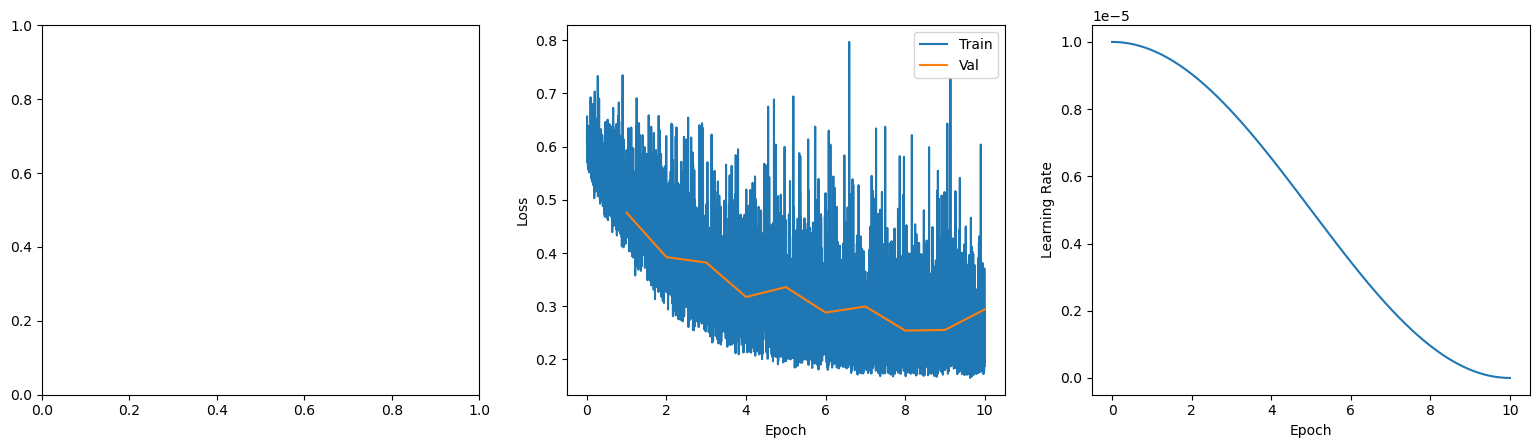

In [31]:
torch.cuda.empty_cache()
model_factory = Unet
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict(
    lr=1e-5, #better 1e-5
    weight_decay=1e-8, #better1e-8
)
data_kwargs = dict(
    batch_size=8, #better 8
    num_images=6400, #6400
    image_dir='training/images_bis',
    mask_dir='training/groundtruth_bis'
)

run_training(
    model_factory=model_factory,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    data_kwargs=data_kwargs,
    device=device,
)

In [20]:
import math
label_file = 'submission.csv'

h = 16
w = h
imgwidth = int(math.ceil((600.0/w))*w)
imgheight = int(math.ceil((600.0/h))*h)
nc = 3

# Convert an array of binary labels to a uint8
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id):
    
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(label_file, 'r')
    lines = f.readlines()
    print(f"First few lines of submission.csv:\n{lines[:10]}")
    image_id_str = '%.3d_' % image_id
    print(f"Reconstructing image {image_id}: {image_id_str}")

    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(',')
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split('_')
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j+w, imgwidth)
        ie = min(i+h, imgheight)
        if prediction == 0:
            adata = np.zeros((w,h))
        else:
            adata = np.ones((w,h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save('prediction_' + '%.3d' % image_id + '.png')

    return im

for i in range(1, 51):
    reconstruct_from_labels(i)

First few lines of submission.csv:
['id,prediction\n', '001_0_0,0\n', '001_0_16,0\n', '001_0_32,1\n', '001_0_48,0\n', '001_0_64,0\n', '001_0_80,0\n', '001_0_96,0\n', '001_0_112,0\n', '001_0_128,0\n']
Reconstructing image 1: 001_
First few lines of submission.csv:
['id,prediction\n', '001_0_0,0\n', '001_0_16,0\n', '001_0_32,1\n', '001_0_48,0\n', '001_0_64,0\n', '001_0_80,0\n', '001_0_96,0\n', '001_0_112,0\n', '001_0_128,0\n']
Reconstructing image 2: 002_
First few lines of submission.csv:
['id,prediction\n', '001_0_0,0\n', '001_0_16,0\n', '001_0_32,1\n', '001_0_48,0\n', '001_0_64,0\n', '001_0_80,0\n', '001_0_96,0\n', '001_0_112,0\n', '001_0_128,0\n']
Reconstructing image 3: 003_
First few lines of submission.csv:
['id,prediction\n', '001_0_0,0\n', '001_0_16,0\n', '001_0_32,1\n', '001_0_48,0\n', '001_0_64,0\n', '001_0_80,0\n', '001_0_96,0\n', '001_0_112,0\n', '001_0_128,0\n']
Reconstructing image 4: 004_
First few lines of submission.csv:
['id,prediction\n', '001_0_0,0\n', '001_0_16,0\n'

In [521]:
# writer = SummaryWriter()

# for epoch in range(num_epochs):
#     writer.add_scalar("Loss/train", loss.item(), epoch)
#     writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], epoch)

# writer.close()